# ✍️ 문장 유형 분류 AI 경진대회

대회 주소 및 데이터 출처 : https://dacon.io/competitions/official/236037/overview/description

<br/>

### 📌 Background
하루 종일 한 마디도 하지 않는 날은 상상할 수 있지만, 한 글자도 읽지 않는 날은 상상할 수 없는 것처럼 우리는 수많은 문장과 글 속에 둘러싸여 살고 있습니다.

<br/>

특히나 코로나19 이후, 우리 사회에선 온라인과 비대면 소통이 주된 교류 방식이 되었습니다.

전 세대에 걸쳐 대면 만남을 선호하는 비율은 감소하고, 모바일 메신저를 선호하는 비율은 상승했다는 조사 결과가 있을 정도로 이미 언택트는 하나의 생활 문화로 자리 잡았는데요.

그만큼 우리는 이전보다도 더 많은 문장을 읽고 쓰며 세상과 소통하고 있습니다.

<br/>

온갖 서비스를 경험하는 과정에서 우린 하루에도 셀 수 없을 만큼 무수한 문장들을 새로이 접하게 되는데요.

<br/>

이처럼 수많은 글들을 AI 모델을 활용해 학습하고, 빠르게 분류할 수 있다면

우리는 더 정교하게 분류된 정보를 얻고, 이를 통해 언어가 쓰이는 모든 영역에서 보다 사용자 친화적인 서비스를 경험할 수 있게 될 것입니다.

<br/>

여기서 한발 더 나아가 한국어 인공지능 기술 고도화의 발판을 마련할 수 있도록, **창의적인 문장 유형 분류 AI 모델**을 만들어 주세요!

<br/>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [2]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
!pip install koreanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 31.0 MB/s 


In [4]:
# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [5]:
# 한글 시각화 라이브러리
!pip install koreanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [7]:
CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed RandomSeed

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [9]:
from glob import glob
glob('/content/drive/MyDrive/Likelion AIS7/sentence_category/*')

['/content/drive/MyDrive/Likelion AIS7/sentence_category/train.csv',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/test.csv',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/sample_submission.csv',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/seul_sentence_category_bert_1.h5',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/model_state_dict_1.pt',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/all_1.tar',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/seul_BERT_submit_v1.csv',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/seul_BERT_submit_v3.csv',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/seul_sentence_category_BERT_v2.h5',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/model_state_dict_v2.pt',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/all_v2.tar',
 '/content/drive/MyDrive/Likelion AIS7/sentence_category/seul_BERT_submit_v2.csv',
 '/content/drive/MyDrive/Likelion AIS7/sentenc

In [10]:
base_path = '/content/drive/MyDrive/Likelion AIS7/sentence_category'
data = pd.read_csv(f'{base_path}/train.csv')
test = pd.read_csv(f'{base_path}/test.csv')
display(data.head(2))
display(test.head(2))

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실


,ID,문장
0,TEST_0000,"장욱진의 ＇가족＇은 허물 없는 가족애를, 처음 공개되는 정약용의 ＇정효자전＇과 ＇정..."
1,TEST_0001,"조지 W 부시, 버락 오바마 전 대통령도 전쟁 위험 때문에 버린 카드다."


In [11]:
data.shape, test.shape

((16541, 7), (7090, 2))

## EDA

1️⃣ 각 라벨에 대한 빈도수 <br/>
2️⃣ 통합 라벨에 대한 빈도수


### BEFORE pororo

#### 1️⃣ 각 라벨에 대한 빈도수

유형 / 극성 / 시제 / 확실성

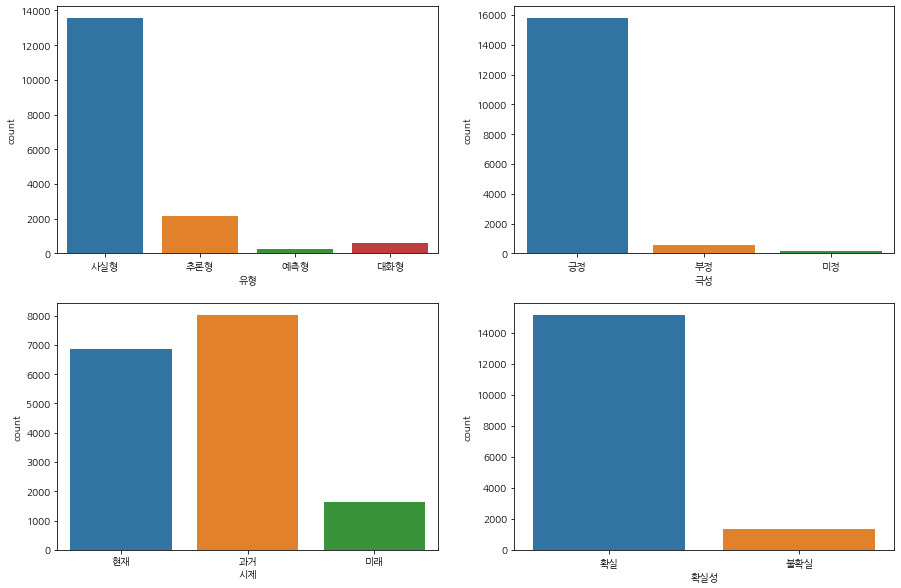

In [12]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))
sns.countplot(data = data, x = '유형', ax = axes[0][0]);
sns.countplot(data = data, x = '극성', ax = axes[0][1]);
sns.countplot(data = data, x = '시제', ax = axes[1][0]);
sns.countplot(data = data, x = '확실성', ax = axes[1][1]);

#### 2️⃣ 통합 라벨에 대한 빈도수



```
유형 - 극성 - 시제 - 확실성
```



In [13]:
from collections import Counter
print('Original dataset shape ⬇️')
print(Counter(data["label"]))

Original dataset shape ⬇️
Counter({'사실형-긍정-과거-확실': 7113, '사실형-긍정-현재-확실': 4743, '추론형-긍정-현재-확실': 1101, '사실형-긍정-미래-확실': 649, '추론형-긍정-과거-확실': 335, '대화형-긍정-현재-확실': 257, '사실형-긍정-미래-불확실': 236, '추론형-긍정-미래-확실': 204, '사실형-긍정-현재-불확실': 200, '사실형-부정-과거-확실': 183, '사실형-부정-현재-확실': 174, '추론형-긍정-미래-불확실': 167, '사실형-긍정-과거-불확실': 144, '예측형-긍정-미래-불확실': 141, '추론형-긍정-현재-불확실': 130, '대화형-긍정-과거-확실': 120, '추론형-부정-현재-확실': 93, '예측형-긍정-미래-확실': 57, '추론형-긍정-과거-불확실': 49, '대화형-긍정-현재-불확실': 44, '대화형-미정-현재-불확실': 29, '대화형-긍정-미래-확실': 26, '사실형-미정-미래-확실': 26, '대화형-긍정-미래-불확실': 22, '대화형-미정-미래-불확실': 22, '사실형-미정-미래-불확실': 22, '추론형-미정-미래-불확실': 20, '사실형-미정-현재-확실': 18, '추론형-부정-과거-확실': 16, '대화형-긍정-과거-불확실': 16, '사실형-부정-미래-확실': 14, '대화형-부정-현재-확실': 14, '예측형-긍정-현재-확실': 13, '사실형-부정-현재-불확실': 11, '예측형-미정-미래-불확실': 10, '사실형-부정-과거-불확실': 10, '예측형-긍정-과거-확실': 10, '대화형-미정-과거-불확실': 10, '추론형-부정-현재-불확실': 9, '예측형-긍정-과거-불확실': 8, '예측형-긍정-현재-불확실': 8, '추론형-부정-미래-확실': 7, '사실형-미정-현재-불확실': 7, '사실형-부정-미래-불확실': 6, '추론형-부정-과거-불확실': 6, '대화형-부정-과거-확실': 5, '추론형-부정-미래

In [14]:
counter = Counter(data['label'])
counter = dict(counter.most_common(20))
counter

{'사실형-긍정-과거-확실': 7113,
 '사실형-긍정-현재-확실': 4743,
 '추론형-긍정-현재-확실': 1101,
 '사실형-긍정-미래-확실': 649,
 '추론형-긍정-과거-확실': 335,
 '대화형-긍정-현재-확실': 257,
 '사실형-긍정-미래-불확실': 236,
 '추론형-긍정-미래-확실': 204,
 '사실형-긍정-현재-불확실': 200,
 '사실형-부정-과거-확실': 183,
 '사실형-부정-현재-확실': 174,
 '추론형-긍정-미래-불확실': 167,
 '사실형-긍정-과거-불확실': 144,
 '예측형-긍정-미래-불확실': 141,
 '추론형-긍정-현재-불확실': 130,
 '대화형-긍정-과거-확실': 120,
 '추론형-부정-현재-확실': 93,
 '예측형-긍정-미래-확실': 57,
 '추론형-긍정-과거-불확실': 49,
 '대화형-긍정-현재-불확실': 44}

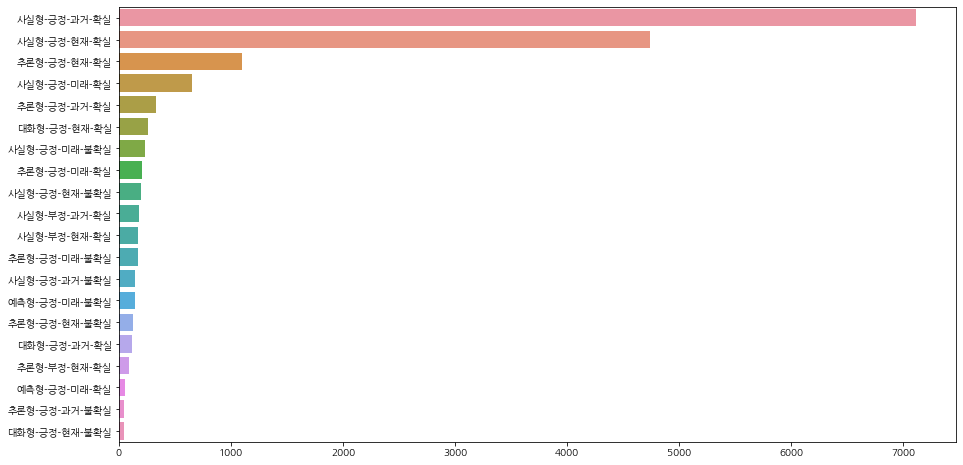

In [15]:
plt.figure(figsize=(15,8))
sns.barplot(y = list(counter.keys()), x = list(counter.values()));

### AFTER pororo

#### pororo 라이브러리 호출

In [16]:
!pip --version

pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)


In [17]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 34.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [18]:
!git clone https://github.com/kakaobrain/pororo.git

Cloning into 'pororo'...
remote: Enumerating objects: 2119, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 2119 (delta 11), reused 22 (delta 8), pack-reused 2090
Receiving objects: 100% (2119/2119), 13.09 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (1448/1448), done.


In [19]:
ls

drive/  pororo/  sample_data/


In [20]:
cd pororo

/content/pororo


In [21]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/pororo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (set

#### pororo 적용

In [22]:
from pororo import Pororo
mt = Pororo(task="translation", lang="multi")

def back_trans_pororo(original_text, lang='en'):
    text_to_lang = mt(original_text, src="ko", tgt=lang)
    new_text = mt(text_to_lang, src=lang, tgt="ko")
    return new_text

In [23]:
tqdm.pandas() # tqdm의 pandas전용 메소드를 호출합니다

In [24]:
tmp_data = data.copy()
us_train = tmp_data[~(tmp_data['유형'].isin(['사실형'])) &
                   (~tmp_data['극성'].isin(['긍정'])) &
                   (~tmp_data['시제'].isin(['현재'])) & 
                   (~tmp_data['확실성'].isin(['확실']))] 

In [25]:
lang = 'en'
pororo_up = us_train.copy() 
pororo_up['문장'] = us_train['문장'].progress_apply(lambda x: back_trans_pororo(x, lang=lang))  

  0%|          | 0/78 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [26]:
pororo_up

,ID,문장,유형,극성,시제,확실성,label
147,TRAIN_00147,바다에는 서해를 중심으로 폭풍과 함께 천둥과 번개가 치는 곳이 있겠습니다.,예측형,미정,미래,불확실,예측형-미정-미래-불확실
431,TRAIN_00431,확인된 임신한 여성이 코로나를 아기나 신생아에게 감염시킬 수 있을까? 와이즈,대화형,미정,미래,불확실,대화형-미정-미래-불확실
436,TRAIN_00436,"지옥의 건물을 형성하기 위해 8명의 전투부대가 공격팀 지도자에게 도전할 수 있으며,...",추론형,미정,미래,불확실,추론형-미정-미래-불확실
671,TRAIN_00671,경영자가 작은 것에 대해 처벌할 수 있다면 금융회사가 위험을 무릅쓰고 혁신적인 자금...,추론형,부정,미래,불확실,추론형-부정-미래-불확실
741,TRAIN_00741,코로나 19관련 기사를 쓰지 않아도 되는 날이 언제가 될까?,대화형,미정,미래,불확실,대화형-미정-미래-불확실
...,...,...,...,...,...,...,...
15203,TRAIN_15203,문제는 배영재를 범재로 만들 교육의 유해성이 저출산으로 악화될 수 있다는 점이다.,추론형,미정,미래,불확실,추론형-미정-미래-불확실
15217,TRAIN_15217,기준금리 차이가 거의 없거나 미국의 기준 금리 상승 수준에서 역전될 경우 외국인 투...,추론형,미정,미래,불확실,추론형-미정-미래-불확실
15361,TRAIN_15361,티버리아의 전염병의 경우처럼 우리가 이미 알고 있던 감염병이나 새로운 감염 질환이 ...,대화형,미정,미래,불확실,대화형-미정-미래-불확실
15367,TRAIN_15367,팬덤이 지속적으로 유지될 수 있도록 단순 등록권 인증 역할을 넘어 NFT 소유주에게...,추론형,미정,미래,불확실,추론형-미정-미래-불확실


In [27]:
df = pd.concat([data, pororo_up], axis=0)

In [28]:
display(df.sample(5))
df.shape

,ID,문장,유형,극성,시제,확실성,label
14753,TRAIN_14753,스마일게이트는 ＂샬롯은 전장에서 적의 공격으로부터 보다 오래 버틸 수 있게 됐으며 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
12709,TRAIN_12709,룩셈부르크는 19세기 말까지만 하더라도 농업국가였다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실
5103,TRAIN_05103,이런 처방을 받은 환자들이 어떤 상태에 빠질지는 한번 생각해 볼 일이다,추론형,긍정,미래,확실,추론형-긍정-미래-확실
8135,TRAIN_08135,지난 3월 1일 새벽 6시 김포공항을 이륙하여 2시간 넘게 동해 상공 비행을 마치고...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
13347,TRAIN_13347,"당뇨병의 3대 합병증인 망막증, 신장병, 말초신경장애 등은 온몸에 혈액을 공급하는 ...",추론형,긍정,현재,확실,추론형-긍정-현재-확실


(16619, 7)

#### 1️⃣ 각 라벨에 대한 빈도수

유형 / 극성 / 시제 / 확실성

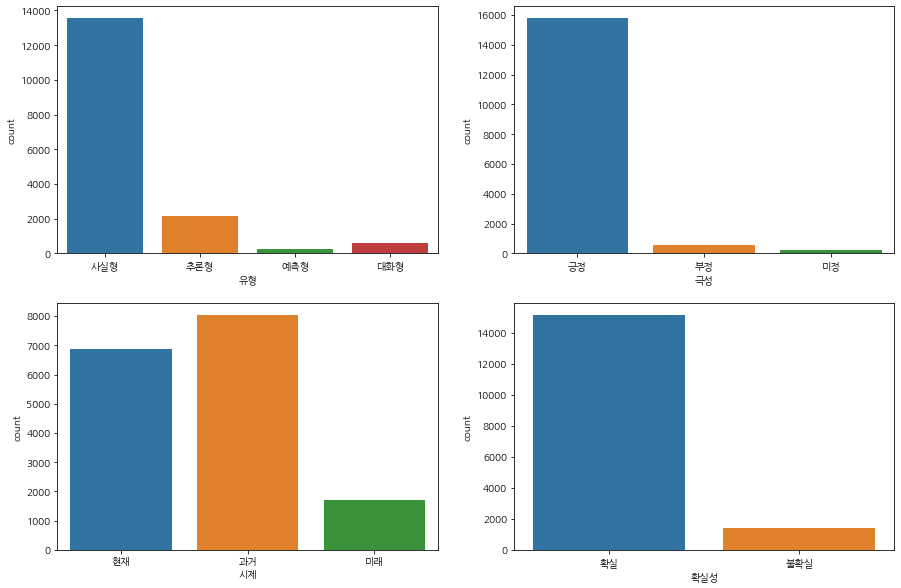

In [29]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))
sns.countplot(data = df, x = '유형', ax = axes[0][0]);
sns.countplot(data = df, x = '극성', ax = axes[0][1]);
sns.countplot(data = df, x = '시제', ax = axes[1][0]);
sns.countplot(data = df, x = '확실성', ax = axes[1][1]);

#### 2️⃣ 통합 라벨에 대한 빈도수



```
유형 - 극성 - 시제 - 확실성
```



In [30]:
from collections import Counter
print('Original dataset shape ⬇️')
print(Counter(df["label"]))

Original dataset shape ⬇️
Counter({'사실형-긍정-과거-확실': 7113, '사실형-긍정-현재-확실': 4743, '추론형-긍정-현재-확실': 1101, '사실형-긍정-미래-확실': 649, '추론형-긍정-과거-확실': 335, '대화형-긍정-현재-확실': 257, '사실형-긍정-미래-불확실': 236, '추론형-긍정-미래-확실': 204, '사실형-긍정-현재-불확실': 200, '사실형-부정-과거-확실': 183, '사실형-부정-현재-확실': 174, '추론형-긍정-미래-불확실': 167, '사실형-긍정-과거-불확실': 144, '예측형-긍정-미래-불확실': 141, '추론형-긍정-현재-불확실': 130, '대화형-긍정-과거-확실': 120, '추론형-부정-현재-확실': 93, '예측형-긍정-미래-확실': 57, '추론형-긍정-과거-불확실': 49, '대화형-긍정-현재-불확실': 44, '대화형-미정-미래-불확실': 44, '추론형-미정-미래-불확실': 40, '대화형-미정-현재-불확실': 29, '대화형-긍정-미래-확실': 26, '사실형-미정-미래-확실': 26, '대화형-긍정-미래-불확실': 22, '사실형-미정-미래-불확실': 22, '예측형-미정-미래-불확실': 20, '대화형-미정-과거-불확실': 20, '사실형-미정-현재-확실': 18, '추론형-부정-과거-확실': 16, '대화형-긍정-과거-불확실': 16, '사실형-부정-미래-확실': 14, '대화형-부정-현재-확실': 14, '예측형-긍정-현재-확실': 13, '추론형-부정-과거-불확실': 12, '사실형-부정-현재-불확실': 11, '추론형-부정-미래-불확실': 10, '사실형-부정-과거-불확실': 10, '예측형-긍정-과거-확실': 10, '추론형-부정-현재-불확실': 9, '예측형-긍정-과거-불확실': 8, '예측형-긍정-현재-불확실': 8, '추론형-부정-미래-확실': 7, '사실형-미정-현재-불확실': 7, '사실형-부정-미래-불확실': 6, '예측형-부정

In [31]:
counter = Counter(df['label'])
counter = dict(counter.most_common(20))
counter

{'사실형-긍정-과거-확실': 7113,
 '사실형-긍정-현재-확실': 4743,
 '추론형-긍정-현재-확실': 1101,
 '사실형-긍정-미래-확실': 649,
 '추론형-긍정-과거-확실': 335,
 '대화형-긍정-현재-확실': 257,
 '사실형-긍정-미래-불확실': 236,
 '추론형-긍정-미래-확실': 204,
 '사실형-긍정-현재-불확실': 200,
 '사실형-부정-과거-확실': 183,
 '사실형-부정-현재-확실': 174,
 '추론형-긍정-미래-불확실': 167,
 '사실형-긍정-과거-불확실': 144,
 '예측형-긍정-미래-불확실': 141,
 '추론형-긍정-현재-불확실': 130,
 '대화형-긍정-과거-확실': 120,
 '추론형-부정-현재-확실': 93,
 '예측형-긍정-미래-확실': 57,
 '추론형-긍정-과거-불확실': 49,
 '대화형-긍정-현재-불확실': 44}

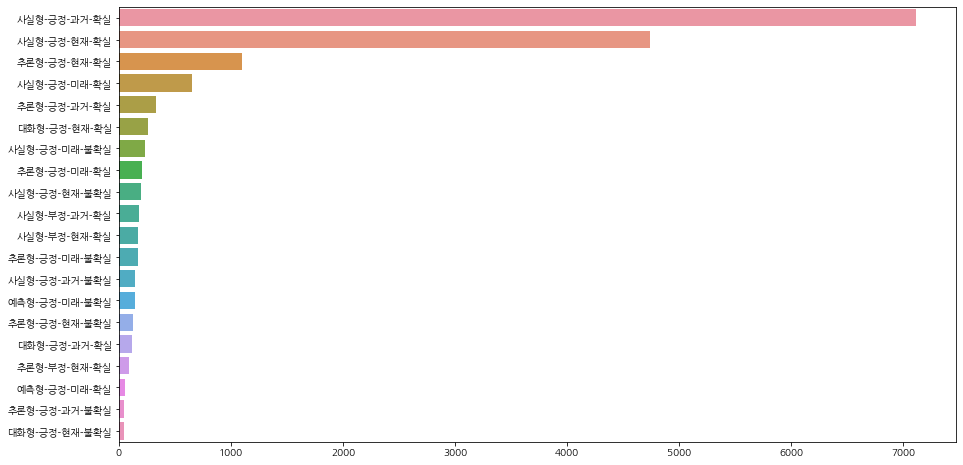

In [32]:
plt.figure(figsize=(15,8))
sns.barplot(y = list(counter.keys()), x = list(counter.values()));

## Train / Validation Split

In [33]:
# 제공된 학습데이터를 학습 / 검증 데이터셋으로 재 분할
# label은 뒤에서 따로 지정해줄 예정 -> (유형 - 긍정 - 시제 - 확실성)
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])

## Data Pre-processing
1️⃣  문장(Text) 벡터화 <br/>
2️⃣ Label Encoding (유형, 극성, 시제, 확실성)

### 1️⃣  문장(Text) 벡터화 

In [34]:
# 1. 문장(Text) 벡터화 -> TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 4, analyzer = 'word', ngram_range=(1, 2))
vectorizer.fit(np.array(train["문장"]))

train_vec = vectorizer.transform(train["문장"])
val_vec = vectorizer.transform(val["문장"])
test_vec = vectorizer.transform(test["문장"])

print(train_vec.shape, val_vec.shape, test_vec.shape)

(13295, 9377) (3324, 9377) (7090, 9377)


In [35]:
train_vec.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

### 2️⃣ Label Encoding 


```
유형 / 극성 / 시제 / 확실성
```



In [36]:
# 2. Label Encoding (유형, 극성, 시제, 확실성)

type_le = preprocessing.LabelEncoder()
train["유형"] = type_le.fit_transform(train["유형"].values)
val["유형"] = type_le.transform(val["유형"].values)


polarity_le = preprocessing.LabelEncoder()
train["극성"] = polarity_le.fit_transform(train["극성"].values)
val["극성"] = polarity_le.transform(val["극성"].values)


tense_le = preprocessing.LabelEncoder()
train["시제"] = tense_le.fit_transform(train["시제"].values)
val["시제"] = tense_le.transform(val["시제"].values)


certainty_le = preprocessing.LabelEncoder()
train["확실성"] = certainty_le.fit_transform(train["확실성"].values)
val["확실성"] = certainty_le.transform(val["확실성"].values)

In [37]:
train_type = train["유형"].values # sentence type
train_polarity = train["극성"].values # sentence polarity
train_tense = train["시제"].values # sentence tense
train_certainty = train["확실성"].values # sentence certainty

train_labels = {
    'type' : train_type,
    'polarity' : train_polarity,
    'tense' : train_tense,
    'certainty' : train_certainty
}
train_labels

{'type': array([3, 1, 1, ..., 0, 1, 1]),
 'polarity': array([0, 0, 0, ..., 0, 0, 0]),
 'tense': array([2, 0, 0, ..., 2, 0, 2]),
 'certainty': array([1, 1, 1, ..., 1, 1, 1])}

In [38]:
val_type = val["유형"].values # sentence type
val_polarity = val["극성"].values # sentence polarity
val_tense = val["시제"].values # sentence tense
val_certainty = val["확실성"].values # sentence certainty

val_labels = {
    'type' : val_type,
    'polarity' : val_polarity,
    'tense' : val_tense,
    'certainty' : val_certainty
}

## Tokenizer


In [39]:
# model_path = "klue/bert-base"
model_path="klue/roberta-small"

In [40]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer

In [42]:
tokenizer = AutoTokenizer.from_pretrained(model_path) #, use_fast=True)

test_sentence = "눈 내리는 크리스마스 이브"
encode_sentence = tokenizer.encode(test_sentence)
decode_sentence = tokenizer.decode(encode_sentence)
encode_sentence, decode_sentence

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

([0, 780, 4848, 2259, 8347, 13422, 2], '[CLS] 눈 내리는 크리스마스 이브 [SEP]')

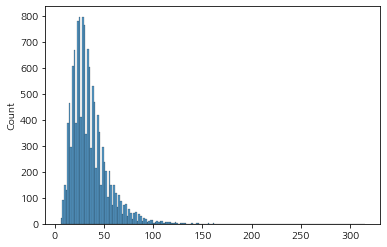

log value : 90.7130471396178


In [43]:
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in train['문장']]
sns.histplot(tokenizer_len)
plt.show()

print(f'log value : {np.mean(tokenizer_len)+3*np.std(tokenizer_len)}')

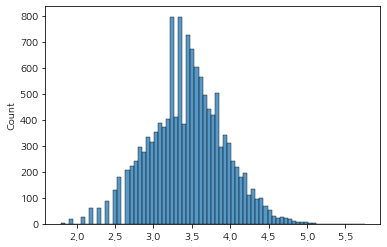

log value : 4.899241197619533
original value : 134.18791893141676


In [44]:
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}')
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

In [45]:
max_len = np.max(df['문장'].apply(lambda x : len(x.split())))
max_len

124

In [46]:
# [CLS] : 문장의 시작을 알림
# [SEP] : 문장의 끝을 알림

def sentence_tokenizer(sentences, max_len, name):
    tokenizer = AutoTokenizer.from_pretrained(model_path) # , do_lower_case=False) # , use_fast=True)

    input_ids = []
    attention_mask = []
    token_type_ids = []
    for sentence in tqdm(sentences):
        encoded = tokenizer.encode_plus(
            text=sentence,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True
        )
        input_ids += [encoded["input_ids"]]
        attention_mask += [encoded["attention_mask"]]
        token_type_ids += [encoded["token_type_ids"]]
        
    
    return torch.tensor(input_ids), torch.tensor(attention_mask), torch.tensor(token_type_ids)

In [47]:
input_train, attention_mask_train, token_type_train = sentence_tokenizer(train["문장"], max_len, model_path)
input_val, attention_mask_val, token_type_val = sentence_tokenizer(val["문장"], max_len, model_path)
input_test, attention_mask_test, token_type_test = sentence_tokenizer(test["문장"], max_len, model_path)

  0%|          | 0/13295 [00:00<?, ?it/s]

  0%|          | 0/3324 [00:00<?, ?it/s]

  0%|          | 0/7090 [00:00<?, ?it/s]

## Dataset

* 기존 Baseline Dataset 함수 : CustomDataset
* 직접 정의한 Dataset 함수 : **SeulDataset**



In [48]:
# len(df_labels)

In [68]:
class CustomDataset(Dataset):
    def __init__(self, st_vec, st_labels):
        self.st_vec = st_vec
        self.st_labels = st_labels

    def __getitem__(self, index):
        st_vector = torch.FloatTensor(self.st_vec[index].toarray()).squeeze(0)
        if self.st_labels is not None:
            st_type = self.st_labels['type'][index]
            st_polarity = self.st_labels['polarity'][index]
            st_tense = self.st_labels['tense'][index]
            st_certainty = self.st_labels['certainty'][index]
            return st_vector, st_type, st_polarity, st_tense, st_certainty
        else:
            return st_vector

    def __len__(self):
        return len(self.st_vec.toarray())

In [98]:
class SeulDataset(Dataset):
    def __init__(self, data, st_labels, tokenizer, attention_mask):
        self.st_vector = data
        self.st_labels = st_labels
        self.attention_mask = attention_mask

    def __getitem__(self, index):
        st_vector = torch.Tensor(self.st_vector[index]).reshape(-1)
        if self.st_labels is not None:
            st_type = self.st_labels['type'][index]
            st_polarity = self.st_labels['polarity'][index]
            st_tense = self.st_labels['tense'][index]
            st_certainty = self.st_labels['certainty'][index]
            attention_mask = self.attention_mask[index]
            return st_vector, st_type, st_polarity, st_tense, st_certainty, attention_mask
        else:
            attention_mask = self.attention_mask[index]
            return st_vector, attention_mask

    def __len__(self):
        return len(self.st_vector)


## DataLoader

#### **DataLoader**란?

Dataset을 batch기반의 딥러닝모델 학습을 위해서 미니배치 형태로 만들어서 우리가 실제로 학습할 때 이용할 수 있게 형태를 만들어주는 기능을 합니다. 

DataLoader를 통해 Dataset의 전체 데이터가 batch size로 slice되어 공급됩니다. 

In [71]:
train_dataset = SeulDataset(input_train, train_labels, tokenizer, attention_mask_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = SeulDataset(input_val, val_labels, tokenizer, attention_mask_val)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Define

* Baseline Model
* 내가 시도해본 모델 : **BERT Model** / **RoBERTa Model**

In [72]:
from transformers import BertTokenizer, BertModel

In [74]:
import torch.nn as nn

class SeulClassifier(nn.Module):
    def __init__(self, model_name, linear_size, cache_dir):
        super(SeulClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_path, cache_dir=cache_dir)
        self.layers = nn.Sequential(
        
            nn.Dropout(p=self.bert.config.hidden_dropout_prob),
            nn.Linear(in_features=768, out_features=linear_size),
            nn.BatchNorm1d(num_features=linear_size),
            
            # nn.Dropout(p=0.75),
            
        )

        self.type_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=4),
        )
        self.polarity_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=3),
        )
        self.tense_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=3),
        )
        self.certainty_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=2),
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None):
    # def forward(self, input_ids, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # outputs = self.bert(input_ids,token_type_ids=token_type_ids)
        x = self.layers(outputs[1])
        # 문장 유형, 극성, 시제, 확실성을 각각 분류
        type_output = self.type_classifier(x)
        polarity_output = self.polarity_classifier(x)
        tense_output = self.tense_classifier(x)
        certainty_output = self.certainty_classifier(x)
        return type_output, polarity_output, tense_output, certainty_output

## Train & Validation

train 과정과 validation 과정을 다음과 같은 함수로 정의한다.

In [76]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    criterion = {
        'type' : nn.CrossEntropyLoss().to(device),
        'polarity' : nn.CrossEntropyLoss().to(device),
        'tense' : nn.CrossEntropyLoss().to(device),
        'certainty' : nn.CrossEntropyLoss().to(device)
    }
    
    best_loss = 999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for sentence, type_label, polarity_label, tense_label, certainty_label, attention_mask in tqdm(iter(train_loader)):
            sentence = sentence.to(device)
            attention_mask = attention_mask.to(device)

            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            # grad 초기화
            optimizer.zero_grad()
            
            # H(x)
            type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence, attention_mask)
            
            # cost 계산
            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
            # cost로 H(x) 개선
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_type_f1, val_polarity_f1, val_tense_f1, val_certainty_f1 = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] 유형 F1 : [{val_type_f1:.5f}] 극성 F1 : [{val_polarity_f1:.5f}] 시제 F1 : [{val_tense_f1:.5f}] 확실성 F1 : [{val_certainty_f1:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            
    return best_model

In [77]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    type_labels, polarity_labels, tense_labels, certainty_labels = [], [], [], []
    
    
    with torch.no_grad():
        for sentence, type_label, polarity_label, tense_label, certainty_label, attention_mask in tqdm(iter(val_loader)):
            sentence = sentence.to(device)
            attention_mask = attention_mask.to(device)

            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence, attention_mask)
            
            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
            val_loss.append(loss.item())
            
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            type_labels += type_label.detach().cpu().numpy().tolist()
            
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_labels += polarity_label.detach().cpu().numpy().tolist()
            
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_labels += tense_label.detach().cpu().numpy().tolist()
            
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_labels += certainty_label.detach().cpu().numpy().tolist()
    
    type_f1 = f1_score(type_labels, type_preds, average='weighted')
    polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
    tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
    certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')
    
    return np.mean(val_loss), type_f1, polarity_f1, tense_f1, certainty_f1

## Run!!

모델 학습 시작 !!

In [78]:
model_path

'klue/roberta-small'

In [79]:
# model = BaseModel()
model = SeulClassifier(model_path, 512, 'bert_ckpt')

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [80]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                       patience=2,threshold_mode='abs',
                                                       min_lr=1e-5, verbose=True,)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.71172] Val Loss : [0.42789] 유형 F1 : [0.85642] 극성 F1 : [0.95452] 시제 F1 : [0.88496] 확실성 F1 : [0.91354]


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.55621] Val Loss : [0.42577] 유형 F1 : [0.86728] 극성 F1 : [0.96001] 시제 F1 : [0.87146] 확실성 F1 : [0.87287]


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.42457] Val Loss : [0.42104] 유형 F1 : [0.87364] 극성 F1 : [0.96453] 시제 F1 : [0.88232] 확실성 F1 : [0.91435]


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.30916] Val Loss : [0.43997] 유형 F1 : [0.82726] 극성 F1 : [0.96062] 시제 F1 : [0.85870] 확실성 F1 : [0.91652]


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.22474] Val Loss : [0.53855] 유형 F1 : [0.88172] 극성 F1 : [0.95853] 시제 F1 : [0.88039] 확실성 F1 : [0.92145]


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.15843] Val Loss : [0.44234] 유형 F1 : [0.88587] 극성 F1 : [0.96524] 시제 F1 : [0.88743] 확실성 F1 : [0.92031]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.10739] Val Loss : [0.43916] 유형 F1 : [0.88481] 극성 F1 : [0.96583] 시제 F1 : [0.89733] 확실성 F1 : [0.91703]


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.07715] Val Loss : [0.53660] 유형 F1 : [0.88260] 극성 F1 : [0.96787] 시제 F1 : [0.89155] 확실성 F1 : [0.92567]


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.06085] Val Loss : [0.59630] 유형 F1 : [0.88158] 극성 F1 : [0.96867] 시제 F1 : [0.89026] 확실성 F1 : [0.92027]
Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.04574] Val Loss : [0.56984] 유형 F1 : [0.88808] 극성 F1 : [0.96906] 시제 F1 : [0.89135] 확실성 F1 : [0.91788]


### Save Model & Parameters

In [81]:
version = 1;
while os.path.isfile(f'{base_path}/seul_ROBERTA_submit_v'+str(version)+'.csv'):
      version+=1
version

2

In [109]:
# torch.save(model, f'{base_path}/seul_sentence_category_BERT_v2.h5') # 전체 모델 저장
# torch.save(model.state_dict(), f'{base_path}/model_state_dict_v2.pt')  # 모델 객체의 state_dict 저장
# torch.save({
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict()
# }, f'{base_path}/all_v2.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

## Inference

test data 의 label 값을 예측해보자 !

In [99]:
test_dataset = SeulDataset(input_test, None, tokenizer, attention_mask=attention_mask_test)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [100]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    
    with torch.no_grad():
        for sentence, attention_mask in tqdm(test_loader):
            sentence = sentence.to(device)
            attention_mask = attention_mask.to(device)

            type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence, attention_mask)
            
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            
    return type_preds, polarity_preds, tense_preds, certainty_preds

In [101]:
type_preds, polarity_preds, tense_preds, certainty_preds = inference(model, test_loader, device)

  0%|          | 0/111 [00:00<?, ?it/s]

In [102]:
type_preds = type_le.inverse_transform(type_preds)
polarity_preds = polarity_le.inverse_transform(polarity_preds)
tense_preds = tense_le.inverse_transform(tense_preds)
certainty_preds = certainty_le.inverse_transform(certainty_preds)

In [103]:
predictions = []
for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)

In [104]:
set(predictions)

{'대화형-긍정-과거-불확실',
 '대화형-긍정-과거-확실',
 '대화형-긍정-미래-불확실',
 '대화형-긍정-미래-확실',
 '대화형-긍정-현재-불확실',
 '대화형-긍정-현재-확실',
 '대화형-미정-과거-불확실',
 '대화형-미정-미래-불확실',
 '대화형-미정-현재-불확실',
 '대화형-부정-과거-확실',
 '대화형-부정-미래-불확실',
 '대화형-부정-현재-불확실',
 '대화형-부정-현재-확실',
 '사실형-긍정-과거-불확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-미래-불확실',
 '사실형-긍정-미래-확실',
 '사실형-긍정-현재-불확실',
 '사실형-긍정-현재-확실',
 '사실형-미정-과거-불확실',
 '사실형-미정-미래-불확실',
 '사실형-부정-과거-확실',
 '사실형-부정-미래-불확실',
 '사실형-부정-미래-확실',
 '사실형-부정-현재-불확실',
 '사실형-부정-현재-확실',
 '예측형-긍정-과거-불확실',
 '예측형-긍정-과거-확실',
 '예측형-긍정-미래-불확실',
 '예측형-긍정-미래-확실',
 '예측형-긍정-현재-불확실',
 '예측형-미정-미래-불확실',
 '추론형-긍정-과거-불확실',
 '추론형-긍정-과거-확실',
 '추론형-긍정-미래-불확실',
 '추론형-긍정-미래-확실',
 '추론형-긍정-현재-불확실',
 '추론형-긍정-현재-확실',
 '추론형-미정-과거-불확실',
 '추론형-미정-미래-불확실',
 '추론형-부정-과거-불확실',
 '추론형-부정-과거-확실',
 '추론형-부정-미래-불확실',
 '추론형-부정-현재-불확실',
 '추론형-부정-현재-확실'}

## Submission

예측값 제출하기

> 제출주소 : https://dacon.io/competitions/official/236037/mysubmission


In [105]:
submit = pd.read_csv(f'{base_path}/sample_submission.csv')
submit.shape

(7090, 2)

In [106]:
submit['label'] = predictions

In [107]:
submit.to_csv(f'{base_path}/seul_ROBERTA_submit_v{version}.csv', index=False)

In [108]:
# v1 BERT                                       0.570
# v2 BERT + pororo                              0.637

# v1 ROBERTA-small + pororo                     0.708
# v2 ROBERTA-small + pororo + attention_mask    